In [26]:
from gnncloudmanufacturing.data import read_fatahi_dataset
from gnncloudmanufacturing.mip_solver import mip_solve
from gnncloudmanufacturing.validation import total_cost_from_gamma, check_feasibility
from gnncloudmanufacturing.utils import delta_from_gamma

import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

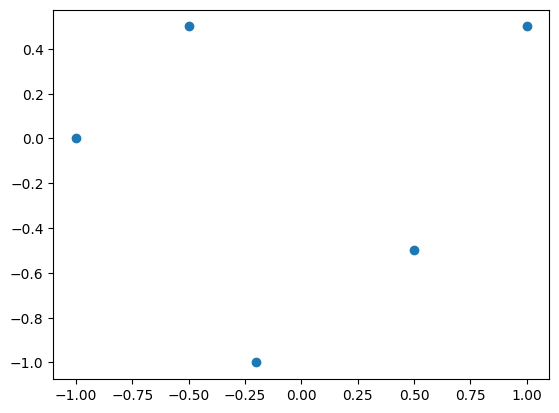

In [59]:
X = np.array([
    [-1.0,  0.0],
    [-0.5,  0.5],
    [-0.2, -1.0],
    [ 0.5, -0.5],
    [ 1.0,  0.5],
])
plt.scatter(X[:, 0], X[:, 1]);

In [60]:
dist = np.sum((X[:, None, :] - X[None, :, :])**2, axis=2)**0.5
print(dist)

[[0.         0.70710678 1.28062485 1.58113883 2.06155281]
 [0.70710678 0.         1.52970585 1.41421356 1.5       ]
 [1.28062485 1.52970585 0.         0.86023253 1.92093727]
 [1.58113883 1.41421356 0.86023253 0.         1.11803399]
 [2.06155281 1.5        1.92093727 1.11803399 0.        ]]


In [61]:
pd.DataFrame(dist).to_excel('dist.xlsx')

In [62]:
dataset = read_fatahi_dataset('toy.xlsx', sheet_names=['1,4,5-1'])
problem = dataset[0]
problem.keys()

  0%|          | 0/1 [00:00<?, ?it/s]

dict_keys(['name', 'n_tasks', 'n_operations', 'n_cities', 'n_services', 'operation', 'dist', 'time_cost', 'op_cost', 'productivity', 'transportation_cost'])

In [63]:
n_tasks = problem['n_tasks']
n_operations = problem['n_operations']
n_cities = problem['n_cities']
n_services = problem['n_services']
operation = problem['operation']
dist = problem['dist']
time_cost = problem['time_cost']
op_cost = problem['op_cost']
productivity = problem['productivity']
transportation_cost = problem['transportation_cost']

In [64]:
problem['n_tasks'], problem['n_operations'], problem['n_cities'], problem['n_services']

(1, 4, 5, 1)

In [65]:
city_names = [f'city {i}' for i in range(n_cities)]
op_names = [f'operation {i+1}' for i in range(n_operations)]
tasks = [f'task {i+1}' for i in range(n_tasks)]
print('operation:')
display(pd.DataFrame(operation.astype(int), index=op_names, columns=tasks))
print('distance:')
display(pd.DataFrame(dist.round(2), index=city_names, columns=city_names))
print('time cost:')
display(pd.DataFrame(time_cost.round(2), index=op_names, columns=city_names))
print('operation cost:')
display(pd.DataFrame(op_cost.round(2), index=op_names, columns=city_names))
print('productivity:')
display(pd.DataFrame(productivity[None, :].round(2), columns=city_names))
print('transportation cost: ', transportation_cost)

operation:


,task 1
operation 1,1
operation 2,1
operation 3,1
operation 4,1


distance:


,city 0,city 1,city 2,city 3,city 4
city 0,0.00,0.71,1.28,1.58,2.06
city 1,0.71,0.00,1.53,1.41,1.50
city 2,1.28,1.53,0.00,0.86,1.92
city 3,1.58,1.41,0.86,0.00,1.12
city 4,2.06,1.50,1.92,1.12,0.00


time cost:


,city 0,city 1,city 2,city 3,city 4
operation 1,1.0,99.0,1.0,99.0,99.0
operation 2,1.0,1.0,99.0,99.0,99.0
operation 3,1.0,99.0,1.0,99.0,99.0
operation 4,99.0,1.0,99.0,1.0,1.0


operation cost:


,city 0,city 1,city 2,city 3,city 4
operation 1,2.0,999.0,1.0,999.0,999.0
operation 2,2.0,2.0,999.0,999.0,999.0
operation 3,2.0,999.0,1.0,999.0,999.0
operation 4,999.0,2.0,999.0,2.0,1.0


productivity:


,city 0,city 1,city 2,city 3,city 4
0,1.0,1.0,1.0,1.0,1.0


transportation cost:  [0.3]


In [66]:
operation_index = []
for i in range(n_tasks):
    for j in range(n_operations):
        if operation[j, i] == 1:
            operation_index.append((i, j))
operation_index = np.array(operation_index)
operation_index

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3]])

In [67]:
full_op_names = [f'{i}_{j}' for (i, j) in operation_index]

In [68]:
adj_operation = np.zeros((operation_index.shape[0], operation_index.shape[0]))
for i in range(operation.shape[1]):
    col_i = operation[:, i]
    path = np.where(col_i > 0)[0]
    for j in range(len(path) - 1):
        u = operation_index.tolist().index([i, path[j]])
        v = operation_index.tolist().index([i, path[j+1]])
        adj_operation[u, v] = 1
display(pd.DataFrame(adj_operation, index=full_op_names, columns=full_op_names).astype(int))

,0_0,0_1,0_2,0_3
0_0,0,1,0,0
0_1,0,0,1,0
0_2,0,0,0,1
0_3,0,0,0,0


In [69]:
full_time_cost = np.tile(time_cost, (operation.shape[1], 1))
full_time_cost = full_time_cost[operation.T.reshape(-1).astype(bool)]
display(pd.DataFrame(full_time_cost, index=full_op_names, columns=city_names))

,city 0,city 1,city 2,city 3,city 4
0_0,1.0,99.0,1.0,99.0,99.0
0_1,1.0,1.0,99.0,99.0,99.0
0_2,1.0,99.0,1.0,99.0,99.0
0_3,99.0,1.0,99.0,1.0,1.0


In [96]:
full_op_cost = np.tile(op_cost, (operation.shape[1], 1))
full_op_cost = full_op_cost[operation.T.reshape(-1).astype(bool)]
display(pd.DataFrame(full_op_cost, index=full_op_names, columns=city_names))

,city 0,city 1,city 2,city 3,city 4
0_0,2.0,999.0,1.0,999.0,999.0
0_1,2.0,2.0,999.0,999.0,999.0
0_2,2.0,999.0,1.0,999.0,999.0
0_3,999.0,2.0,999.0,2.0,1.0


In [71]:
city_to_op = [(city_names[i], full_op_names[j]) for i, j in zip(*np.where(full_op_cost < 999)[::-1])]
op_to_op = [(full_op_names[i], full_op_names[j]) for i, j in zip(*np.where(adj_operation > 0))]
city_to_city = [(city_names[i], city_names[j]) for i, j in zip(*np.where(dist > 0))]

In [81]:
G = nx.DiGraph()
G.add_nodes_from(full_op_names)
G.add_nodes_from(city_names)
G.add_edges_from(city_to_op)
G.add_edges_from(op_to_op)
G.add_edges_from(city_to_city)
pos = dict()
for i, oname in enumerate(full_op_names):
    pos[oname] = list(operation_index[i][::-1])
for i in range(n_cities):
    pos[f'city {i}'] = X[i] + [1.5, 2.5]

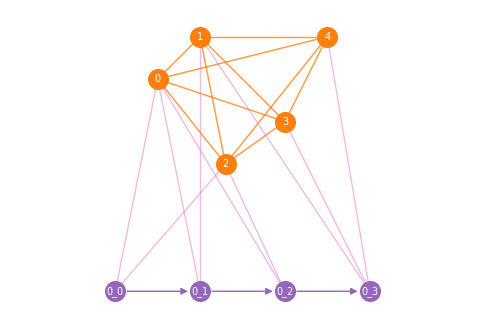

In [82]:
plt.figure(figsize=(6, 4))
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=full_op_names,
    node_size=200,
    node_color='tab:purple',
)
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=city_names,
    node_size=200,
    node_color='tab:orange',
)
nx.draw_networkx_labels(
    G, 
    pos,
    labels={node: node for node in full_op_names},
    font_color='white', 
    font_size=7,
)
nx.draw_networkx_labels(
    G, 
    pos,
    labels={node: node[5:] for node in city_names},
    font_color='white', 
    font_size=7,
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=op_to_op,
    edge_color='tab:purple',
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=city_to_city,
    edge_color='tab:orange',
    arrows=False,
    alpha=0.5,
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=city_to_op,
    edge_color='tab:pink',
    arrows=False,
    alpha=0.5,
)
plt.axis('equal')
plt.axis('off')
plt.show()

In [86]:
gamma = np.array([
    [0., 0., 1., 0., 0.],
    [1., 0., 0., 0., 0.],
    [0., 0., 1., 0., 0.],
    [0., 0., 0., 0., 1.],
])[:, None, :]
delta = delta_from_gamma(problem, gamma)
check_feasibility(gamma, delta, problem)
total_cost = total_cost_from_gamma(problem, gamma, delta)

print(f'Problem {problem["name"]}: {total_cost:.2f}')

Problem 1,4,5-1: 6.34


In [87]:
city_to_op_solution = []
for o, t, c in zip(*np.where(gamma == 1)):
    city_to_op_solution.append((f'city {c}', f'{t}_{o}'))

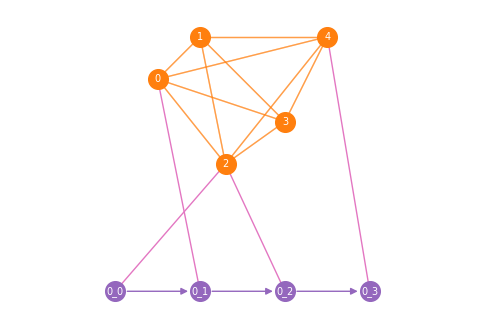

In [88]:
plt.figure(figsize=(6, 4))
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=full_op_names,
    node_size=200,
    node_color='tab:purple',
)
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=city_names,
    node_size=200,
    node_color='tab:orange',
)
nx.draw_networkx_labels(
    G, 
    pos,
    labels={node: node for node in full_op_names},
    font_color='white', 
    font_size=7,
)
nx.draw_networkx_labels(
    G, 
    pos,
    labels={node: node[5:] for node in city_names},
    font_color='white', 
    font_size=7,
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=op_to_op,
    edge_color='tab:purple',
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=city_to_city,
    edge_color='tab:orange',
    arrows=False,
    alpha=0.5,
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=city_to_op_solution,
    edge_color='tab:pink',
    arrows=False,
)
plt.axis('equal')
plt.axis('off')
plt.show()